In [2]:
!pip install profet empiarreader caked gemmi

# 1. Bulk download of EMPIAR data and load into ML project

In this section we will use `empiarreader` package to bulk download 2 EMPIAR datasets. We will limit the download to 10 micrographs each for the purpose of this demo.

After that, we will use `caked` to load all data into a dataloader which can be used with your machine learning model in `pytorch`. `caked` expects your data to be formatted as follows: `<class_ID>_<metadata>.<file_extension>`, where `class_id` refers to data labels you want to learn to differentiate in your model, `metadata` is any extra data you might wish to retain about your file which you can also access when loading data during training, and `file_extension` is currently limited to `.npy` or `.mrc` files. If you want to use a specialised file we don't support, just load it in python and re-save as `.npy` array. Also we will apply a rescaling to all our images. `caked` stores data paths and will only read the files when they're accessed, so it can deal with large amounts of data required for ML without overwhelming the memory.

In [3]:
EMPIAR_ID_1 = 11924  # https://www.ebi.ac.uk/empiar/EMPIAR-11924/
EMPIAR_ID_2 = 12002  # https://www.ebi.ac.uk/empiar/EMPIAR-12002/

In [ ]:
def download_empiar(empiar_id, search_for):
    # Browse EMPIAR data with empiarreader and download data
    import empiarreader as er

    catalog = er.EmpiarCatalog(empiar_id)
    catalog_dir = list(catalog.keys())
    print("\nBrowsing", empiar_id, "...")

    print("Available datasets:")
    for i, d in enumerate(catalog_dir):
        print("    ", i, d)
        if search_for in d:
            chosen_catalog_dir = d

    dataset = catalog[chosen_catalog_dir]
    base_dir = dataset.directory
    print("\nMain micrograph directory found at", base_dir)
    print()

    ds = er.EmpiarSource(empiar_id, directory=base_dir, filename=".*.mrc", regexp=True)

    # Save data to disk
    import mrcfile
    import os

    if os.path.exists("empiar") == False:
        os.mkdir("empiar")
    for i in range(10):
        filename = "empiar/{}_{}.mrc".format(empiar_id, i)
        with mrcfile.new(filename, overwrite=True) as mrc:
            mrc.set_data(ds.read_partition(i))
            print("Saved at:", filename)


download_empiar(EMPIAR_ID_1, search_for="Aligned")
download_empiar(EMPIAR_ID_2, search_for="Aligned")


Browsing 11924 ...
Available datasets:
     0 Unaligned multi-frame micrographs of ArnC from S. enterica in the apo state collected on Talos Arctica
     1 Aligned and dose-weighted micrographs of ArnC from S. enterica in the apo state collected on Talos Arctica
     2 Final particle stack of ArnC from S. enterica in the apo state collected on Talos Arctica

Main micrograph directory found at data/aligned

Saved at: empiar/11924_0.mrc
Saved at: empiar/11924_1.mrc
Saved at: empiar/11924_2.mrc
Saved at: empiar/11924_3.mrc
Saved at: empiar/11924_4.mrc


In [ ]:
from caked.dataloader import DiskDataLoader

# Define a dataloader and lazy load data
loader = DiskDataLoader(
    pipeline="disk",
    classes=[str(EMPIAR_ID_1), str(EMPIAR_ID_2)],
    training=True,
    transformations=["rescale=1000"],
)
loader.load("empiar", datatype="mrc")

# Train a model
for image, label in loader.dataset:
    print(image.shape, label)

    # your model here
    # model = MyModel()
    # y = model.forward(image)
    break

# 2. Download EMPIAR and PDB data and load with a custom loader into ML project

 In this section of the notebook we will download some data both from PDB database with `profet` as well as from EMPIAR with `empiarreader`. For the EMPIAR data, unlike previously where we downloaded just the base micrograph directory, here we will search through the directory structure to find a postprocessed denssty map. We will also download a corresponding PDB model for it with `profet`, from which we will extract atom co-ordinates with `gemmi`, but another common scenario would be to use `gemmi` to simulate electron density from the atomic model.

 Let's assume we want to train some ML model that learns a mapping between a map and its model, we would like `caked` to load a pair of images as a sample and serve them instantaneously to the model. Currently `caked` only supports loading a single image per sample along with their labels, however, it's been designed in a way that is easily extendible so you can adapt it to your own needs. Here we will write an extended caked dataset class to help us load a pair of images ready for training.

In [3]:
PDB_ID = "7QK5"  # https://www.rcsb.org/structure/7U6Q
EMPIAR_ID = 10943  # https://www.ebi.ac.uk/empiar/EMPIAR-10943/

In [1]:
# Download PDB data with profet
import profet

fetcher = profet.Fetcher()
pdb = fetcher.get_file(PDB_ID, filesave=True)
print()

# Access model and save coordinates
import gemmi
import numpy as np

model_str = pdb[1]
model_gemmi = gemmi.cif.read_string(model_str)
block = model_gemmi.sole_block()
structure = gemmi.make_structure_from_block(block)[0]
model_coords = []
for chain in structure:
    for residue in chain:
        for atom in residue:
            model_coords.append([atom.pos.x, atom.pos.y, atom.pos.z])
model_coords = np.asarray(model_coords)
print("Model coordinates shape:", model_coords.shape)

# Save data
import os
import numpy as np

if os.path.exists("profet-empiar") == False:
    os.mkdir("profet-empiar")
filename = "profet-empiar/{}_model.npy".format(EMPIAR_ID)
np.save(filename, model_coords)
print("Saved at:", filename)

NameError: name 'PDB_ID' is not defined

In [ ]:
# Browse EMPIAR data with empiarreader
import empiarreader as er

catalog = er.EmpiarCatalog(EMPIAR_ID)
catalog_dir = list(catalog.keys())[0]  # take first dataset entry
dataset = catalog[catalog_dir]
base_dir = dataset.directory
print("Main micrograph directory found at", base_dir)

Main micrograph directory found at data/Tiff


Job type found: PostProcess
Last job number available: job105
Found file: postprocess.mrc
Found file: postprocess_masked.mrc



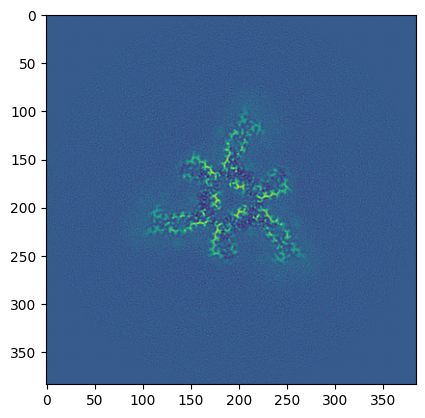

(384, 384, 384) 

Saved at: profet-empiar/10943_map.npy


In [ ]:
# Find and download a specific directory and specific entry with empiarreader
base_dir = base_dir.split("/")[0]
looking_for = "PostProcess"
looking_for_ext = ".mrc"
subdirs = (
    !empiarreader search --entry {EMPIAR_ID} --dir {base_dir} --verbose --select "*.mrc"
)

for s in subdirs:
    if looking_for in s:
        s = s.split("/")[-1]
        print("Job type found:", s)  # job type
        base_dir = base_dir + "/" + s
        data = !empiarreader search --entry {EMPIAR_ID} --dir {base_dir} --verbose --select "*.mrc"

        s = data[-1].split("/")[-1]
        print("Last job number available:", s)  # last job
        base_dir = base_dir + "/" + s
        data = !empiarreader search --entry {EMPIAR_ID} --dir {base_dir} --verbose --select "*.mrc"
        for d in data:
            if looking_for_ext in d:
                print("Found file:", d.split("/")[-1])
        break

ds = er.EmpiarSource(EMPIAR_ID, directory=base_dir, filename=".*.mrc", regexp=True)
print()

# Access image
map_img = ds.read_partition(0)
import matplotlib.pyplot as plt

plt.imshow(map_img[map_img.shape[0] // 2, :, :])
plt.show()
print(map_img.shape, "\n")

# Save image
import os
import numpy as np

if os.path.exists("profet-empiar") == False:
    os.mkdir("profet-empiar")
filename = "profet-empiar/{}_map.npy".format(EMPIAR_ID)
np.save(filename, map_img)
print("Saved at:", filename)

In [ ]:
from caked.dataloader import DiskDataset


class DemoDataset(DiskDataset):
    def __init__(self, dataset: DiskDataset):
        super().__init__(
            dataset.paths,
            dataset.datatype,
            dataset.rescale,
            dataset.shiftmin,
            dataset.normalise,
            dataset.gaussianblur,
        )
        self.paths_models = [path for path in self.paths if "_model" in str(path)]
        self.paths_maps = [path for path in self.paths if "_model" not in str(path)]
        print(self.paths_maps)
        print(self.paths_models)

    def __getitem__(self, item):
        self.paths = self.paths_maps
        x_map, y = super().__getitem__(item)
        self.paths = self.paths_models
        x_model, _ = super().__getitem__(item)
        return x_map, x_model, y

In [ ]:
from caked.dataloader import DiskDataLoader

# Define a dataloader and lazy load data
loader = DiskDataLoader(
    pipeline="disk",
    classes=[str(EMPIAR_ID)],
    training=True,
)
loader.load("profet-empiar", datatype="npy")

# Replace loader's dataset with your new overwritten version
loader.dataset = DemoDataset(dataset=loader.dataset)

# Train a model
for image, coords, label in loader.dataset:
    print(image.shape, coords.shape, label)

    # your model here
    # model = MyModel()
    # y = model.forward(image)
    break

[PosixPath('profet-empiar/10943_map.npy')]
[PosixPath('profet-empiar/10943_model.npy')]
torch.Size([1, 384, 384, 384]) torch.Size([1, 10485, 3]) 10943
